In [0]:
!pip install -q tensorflow==2.1.0

In [0]:
!pip install -q tensorflow-quantum

In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

np.random.seed(1234)

In [4]:
def generate_random_qnn(qubits, symbol, depth):
    """Generate random QNN's with the same structure from McClean et al."""
    circuit = cirq.Circuit()
    for qubit in qubits:
        circuit += cirq.ry(np.pi / 4.0)(qubit)

    for d in range(depth):
        # Add a series of single qubit rotations.
        for i, qubit in enumerate(qubits):
            random_n = np.random.uniform()
            random_rot = np.random.uniform() * 2.0 * np.pi if i != 0 or d != 0 else symbol
            if random_n > 2. / 3.:
                # Add a Z.
                circuit += cirq.rz(random_rot)(qubit)
            elif random_n > 1. / 3.:
                # Add a Y.
                circuit += cirq.ry(random_rot)(qubit)
            else:
                # Add a X.
                circuit += cirq.rx(random_rot)(qubit)

        # Add CZ ladder.
        for src, dest in zip(qubits, qubits[1:]):
            circuit += cirq.CZ(src, dest)

    return circuit


generate_random_qnn(cirq.GridQubit.rect(1, 3), sympy.Symbol('theta'), 2)

(0, 0): ───Ry(0.25π)───Rx(theta)────@───Rx(0.553π)────────────────@───────
                                    │                             │
(0, 1): ───Ry(0.25π)───Ry(0.875π)───@───@────────────Rz(1.92π)────@───@───
                                        │                             │
(0, 2): ───Ry(0.25π)───Rz(1.56π)────────@────────────Rz(0.716π)───────@───

In [0]:
def process_batch(circuits, symbol, op):
    """Compute the variance of a batch of expectations w.r.t. op on each circuit that 
    contains `symbol`. Note that this method sets up a new compute graph every time it is
    called so it isn't as performant as possible."""

    # Setup a simple layer to batch compute the expectation gradients.
    expectation = tfq.layers.Expectation()

    # Prep the inputs as tensors
    circuit_tensor = tfq.convert_to_tensor(circuits)
    values_tensor = tf.convert_to_tensor(np.random.uniform(0, 2 * np.pi, (n_circuits, 1)).astype(np.float32))

    # Use TensorFlow GradientTape to track gradients.
    with tf.GradientTape() as g:
        g.watch(values_tensor)
        forward = expectation(circuit_tensor,
                              operators=op,
                              symbol_names=[symbol],
                              symbol_values=values_tensor)

    # Return variance of gradients across all circuits.
    grads = g.gradient(forward, values_tensor)
    grad_var = tf.math.reduce_std(grads, axis=0)
    return grad_var.numpy()[0]

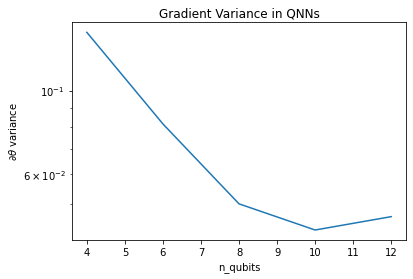

In [6]:
n_qubits = [2 * i for i in range(2, 7)]  # Ranges studied in paper are between 2 and 24.
depth = 50  # Ranges studied in paper are between 50 and 500.
n_circuits = 200
theta_var = []

for n in n_qubits:
    # Generate the random circuits and observable for the given n.
    qubits = cirq.GridQubit.rect(1, n)
    symbol = sympy.Symbol('theta')
    circuits = [
        generate_random_qnn(qubits, symbol, depth) for _ in range(n_circuits)
    ]
    op = cirq.Z(qubits[0]) * cirq.Z(qubits[1])
    theta_var.append(process_batch(circuits, symbol, op))

plt.semilogy(n_qubits, theta_var)
plt.title('Gradient Variance in QNNs')
plt.xlabel('n_qubits')
plt.ylabel('$\\partial \\theta$ variance')
plt.show()

In [7]:
def generate_identity_qnn(qubits, symbol, block_depth, total_depth):
    """Generate random QNN's with the same structure from Grant et al."""
    circuit = cirq.Circuit()

    # Generate initial block with symbol.
    prep_and_U = generate_random_qnn(qubits, symbol, block_depth)
    circuit += prep_and_U

    # Generate dagger of initial block without symbol.
    U_dagger = (prep_and_U[1:])**-1
    circuit += cirq.resolve_parameters(
        U_dagger, param_resolver={symbol: np.random.uniform() * 2 * np.pi})

    for d in range(total_depth - 1):
        # Get a random QNN.
        prep_and_U_circuit = generate_random_qnn(qubits,
            np.random.uniform() * 2 * np.pi, block_depth)

        # Remove the state-prep component
        U_circuit = prep_and_U_circuit[1:]

        # Add U
        circuit += U_circuit

        # Add U^dagger
        circuit += U_circuit**-1

    return circuit


generate_identity_qnn(cirq.GridQubit.rect(1, 3), sympy.Symbol('theta'), 2, 2)

(0, 0): ───Ry(0.25π)───Rx(theta)────@───Rx(0.716π)────────────────@───────────@─────────────────Rx(-0.716π)───@───Rx(-1.62π)────Ry(1.15π)───@───Rz(1.7π)────────────────@───────────@─────────────────Rz(-1.7π)───@───Ry(-1.15π)───
                                    │                             │           │                               │                             │                           │           │                             │
(0, 1): ───Ry(0.25π)───Rz(0.356π)───@───@────────────Rz(0.153π)───@───@───@───@───Rz(-0.153π)───@─────────────@───Rz(-0.356π)───Rz(1.25π)───@───@──────────Rz(0.736π)───@───@───@───@───Rz(-0.736π)───@───────────@───Rz(-1.25π)───
                                        │                             │   │                     │                                               │                           │   │                     │
(0, 2): ───Ry(0.25π)───Rx(0.104π)───────@────────────Ry(0.792π)───────@───@───────Ry(-0.792π)───@─────────────────Rx(-0.104π)───Rz(1.46π)───────@──────────Rz(1.73π)────────@───@───────Rz(-1.73π)────@───────────────Rz(-1.46π)───

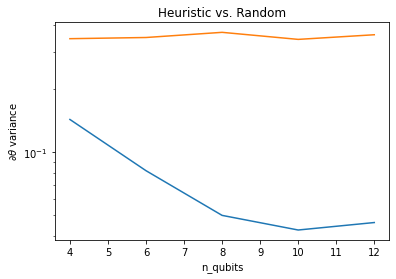

In [8]:
block_depth = 10
total_depth = 5

heuristic_theta_var = []

for n in n_qubits:
    # Generate the identity block circuits and observable for the given n.
    qubits = cirq.GridQubit.rect(1, n)
    symbol = sympy.Symbol('theta')
    circuits = [
        generate_identity_qnn(qubits, symbol, block_depth, total_depth)
        for _ in range(n_circuits)
    ]
    op = cirq.Z(qubits[0]) * cirq.Z(qubits[1])
    heuristic_theta_var.append(process_batch(circuits, symbol, op))

plt.semilogy(n_qubits, theta_var)
plt.semilogy(n_qubits, heuristic_theta_var)
plt.title('Heuristic vs. Random')
plt.xlabel('n_qubits')
plt.ylabel('$\\partial \\theta$ variance')
plt.show()